# Exploratory Data Analysis

In this notebook we do some simple exploratory of the data given.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

In [2]:
metadata = pd.read_csv('data/metadata.csv')
metadata.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [3]:
cars = pd.read_csv('data/train_masks.csv')
cars.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [4]:
cars.shape

(5088, 2)

In [5]:
def get_mask_file(image_file):
    
    img_file_split = image_file.split('.')
    
    mask_file = img_file_split[0] + '_mask.gif'
    
    return mask_file

In [6]:
def get_id(image_file):
    
    imagefile_split = image_file.split('_')

    car_id = imagefile_split[0]
    
    return car_id

In [7]:
cars['mask_file'] = cars['img'].apply(get_mask_file)
cars['id'] = cars['img'].apply(get_id)
cars.head()

,img,rle_mask,mask_file,id
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...,00087a6bd4dc_01_mask.gif,00087a6bd4dc
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...,00087a6bd4dc_02_mask.gif,00087a6bd4dc
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...,00087a6bd4dc_03_mask.gif,00087a6bd4dc
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...,00087a6bd4dc_04_mask.gif,00087a6bd4dc
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...,00087a6bd4dc_05_mask.gif,00087a6bd4dc


In [8]:
cars_final = cars.merge(metadata, on = 'id')
cars_final = cars_final[['id', 'img', 'mask_file', 'rle_mask', 
                   'year', 'make', 'model', 'trim1', 'trim2']]
cars_final.head()

,id,img,mask_file,rle_mask,year,make,model,trim1,trim2
0,00087a6bd4dc,00087a6bd4dc_01.jpg,00087a6bd4dc_01_mask.gif,879386 40 881253 141 883140 205 885009 17 8850...,2014.0,Acura,RLX,RLX,w/Tech
1,00087a6bd4dc,00087a6bd4dc_02.jpg,00087a6bd4dc_02_mask.gif,873779 4 875695 7 877612 9 879528 12 881267 15...,2014.0,Acura,RLX,RLX,w/Tech
2,00087a6bd4dc,00087a6bd4dc_03.jpg,00087a6bd4dc_03_mask.gif,864300 9 866217 13 868134 15 870051 16 871969 ...,2014.0,Acura,RLX,RLX,w/Tech
3,00087a6bd4dc,00087a6bd4dc_04.jpg,00087a6bd4dc_04_mask.gif,879735 20 881650 26 883315 92 883564 30 885208...,2014.0,Acura,RLX,RLX,w/Tech
4,00087a6bd4dc,00087a6bd4dc_05.jpg,00087a6bd4dc_05_mask.gif,883365 74 883638 28 885262 119 885550 34 88716...,2014.0,Acura,RLX,RLX,w/Tech


We merge the matadata and rle mask dataset into one. This will help us control the process of creating the dataset and predictions as well.

The image and mask files will be used later to create the Tensorflow image dataset in the next notebook.

In [9]:
cars_final.shape

(5088, 9)

In [10]:
cars_final['id'].value_counts()

5a194c1384f3    16
31186febd775    16
5ab34f0e3ea5    16
bb7625a3f1d4    16
fdc2c87853ce    16
                ..
ce74dfdf123b    16
f98dbe8a5ee2    16
3cb21125f126    16
33a310ea7462    16
6cc98271f4dd    16
Name: id, Length: 318, dtype: int64

In [11]:
318*16

5088

In [12]:
cars_final.to_csv('data/train_final.csv', index = False)

## Run-Length Encoding and Decoding of Images

For this Kaggle challenge, the submissions are expected to be made in the RLE format.  
For this section we will create and test functions to do both run-length encoding and decoding.

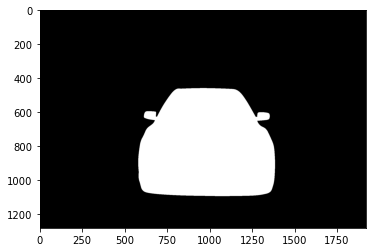

In [13]:
img_true = Image.open('data/sample_masks/00087a6bd4dc_01_mask.gif')
plt.imshow(img_true)

In [14]:
img_array = np.array(img_true)
img_array.shape

(1280, 1918)

In [15]:
def rle_decode(rle_img):
    
    rle_img = rle_img.split(' ')
    
    rle_img = [int(string) for string in rle_img]
    
    rle_tups = []

    for i in range(0, len(rle_img), 2):

        pixel = rle_img[i]

        pixel_position = [pixel//1918, ((pixel%1918))]

        run = rle_img[i+1]

        rle_tups.append([pixel_position, run])
        
    pixel_mask = []
    
    img = np.empty((1280, 1920), dtype=int)

    for tup in rle_tups:

        for i in range(tup[1]):

            img[(tup[0][0])][(tup[0][1]+i)] = 1
        
    return img

In [16]:
cars_final['rle_mask'][0][:50]

'879386 40 881253 141 883140 205 885009 17 885032 2'

In [17]:
rle_1 = rle_decode(cars_final['rle_mask'][0])

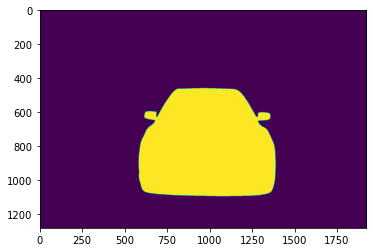

In [18]:
plt.imshow(rle_1)

We changed the Image from Run-Length-Encoded to a regular 1280 X 1918 pixel-array.  
The image matches the actual image we had shown earlier.    


Next we will try to encode a pixel-by-pixel image to Run-Length-Encoding

In [19]:
def rle_encode(img):

    img_array = np.array(img)

    pixels = []

    for i in range(img_array.shape[0]):

        for j in range(img_array.shape[1]):

            if int(img_array[i][j]) != 0:
                
                pix = ((i * 1918) + j + 1)
                pixels.append(pix)

    pixel_breaks = [0]

    for i in range(len(pixels) - 1):

        if pixels[i] != ((pixels[i+1]) - 1):

            pixel_breaks.append(i+1)

    pixel_breaks.append(len(pixels))

    rle_mask = ''

    for i in range(len(pixel_breaks) - 1):

        rle_mask += (str(pixels[pixel_breaks[i]]) + ' ')
        rle_mask += (str(pixel_breaks[i+1] - pixel_breaks[i]) + ' ')

    return rle_mask[:-1]

In [20]:
img_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [21]:
img_array.shape

(1280, 1918)

In [22]:
rle_encode(img_array)[:50]

'879386 40 881253 141 883140 205 885009 17 885032 2'

In [23]:
cars_final['rle_mask'][0][:50]

'879386 40 881253 141 883140 205 885009 17 885032 2'

The two RLE matches, which shows that the function works as intended.